In [1]:
import scipy
from scipy.io import loadmat
from pandas import factorize
import os
import numpy as np
import random

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [2]:
import os
import scipy.io
import numpy as np

def load_dataset(data, snr_range):
    """
    This function loads and processes a dataset represented as a dictionary with keys as tuples of channel codes and SNR values.

    Parameters:
    - data: A dictionary where keys are tuples representing channel codes and SNR values, and values are corresponding data arrays.
    - snr_range: A tuple specifying the range of SNR values to consider.

    Returns:
    A tuple containing:
    - snrs: List of sorted SNR values within the specified range.
    - X: Stacked data arrays corresponding to each channel code and SNR.
    - ch_codes: List of sorted channel codes.
    - one_hot_encode: One-hot encoded representation of channel codes.
    - lbl_SNR: Array of SNR values corresponding to each data vector.
    """

    # Sort by converting each ndarray element to a set
    ch_codes = sorted(set([key[0] for key in data.keys()]))
    snrs = sorted(set([key[1] for key in data.keys() if snr_range[0] <= key[1] <= snr_range[1]]))


    X = []; lbl = []

    for ch_code in ch_codes:
        for snr in snrs:
            X.append(data[(ch_code, snr)])
            for i in range(data[(ch_code, snr)].shape[0]):
                lbl.append((ch_code, snr))

    X = np.vstack(X); lbl=np.vstack(lbl)

    print(X.shape)

    # One-hot-encoding
    Y = []
    for i in range(len(lbl)):
        ch_code = (lbl[i, 0])
        Y.append(ch_code)

    mapping = {}
    for x in range(len(ch_codes)):
        mapping[ch_codes[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(ch_codes)/len(snrs)
    repeat_n_ch_code = len(ch_codes)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_ch_code)

    return snrs, X, ch_codes, one_hot_encode, lbl_SNR

In [3]:
def train_test_valid_split(X, one_hot, train_split=0.8, valid_split=0.1, test_split=0.1):

    """
    Train-Test-Valid split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.8)
        valid_split (default 0.1)
        test_split (default 0.1)
        train_split : valid_split : test_split - ratio for splitting the dataset

        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)

    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))

    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)

    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)

    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test

In [4]:
CH_CODE = ["CONV_5_7", "CONV_13_17", "CONV_23_35"]
classes = CH_CODE

In [5]:
import os
import re
from tqdm import tqdm
from PIL import Image
import numpy as np
import gc

# SNR 범위 
snr = range(-20, 21, 1)

# 데이터셋 저장 절대경로
dataset_dir = r"C:\Users\USER-PC\haneol\DATASET_IMG_SIN" # PYTHON VERSION - IMG_SIN

DATA_DICT = {}

for i in tqdm(snr, desc="Loading Files"):
    print("Now load SNR: " + str(i))

    base_dir = os.path.join(dataset_dir, str(i))

    label_data = {}

    # 디렉토리 내의 모든 .jpg 파일 목록 가져오기
    files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]

    # 각 .jpg 파일에 대해
    for file in tqdm(files, desc=f"SNR {i}", position=0, leave=False):
        # 절대 경로 생성하기
        filepath = os.path.join(base_dir, file)

        # 이미지 열기
        with Image.open(filepath) as image:
            # 이미지를 넘파이 배열로 변환
            image_data = np.array(image)

        # ch_code 값 추출하기 (예시: 문자열로 변환하여 추출)
        ch_code_value = re.sub(r'_\d+\.jpg', '', file)

        # Key에 따라 저장
        key = (ch_code_value, i)
        if key not in label_data:
            label_data[key] = [image_data]
        else:
            label_data[key].append(image_data)

    # 넘파이 배열로 변환된 이미지 데이터를 딕셔너리에 저장
    for key in label_data.keys():
        if key not in DATA_DICT:
            DATA_DICT[key] = np.stack(label_data[key], axis=0)
        else:
            DATA_DICT[key] = np.concatenate([DATA_DICT[key], np.stack(label_data[key], axis=0)], axis=0)
    
    # 가비지 컬렉션 강제 수행
    del label_data
    gc.collect()


Loading Files:   0%|          | 0/41 [00:00<?, ?it/s]

Now load SNR: -20


Loading Files:   2%|▏         | 1/41 [00:01<01:06,  1.65s/it] 

Now load SNR: -19


Loading Files:   5%|▍         | 2/41 [00:03<01:02,  1.61s/it] 

Now load SNR: -18


Loading Files:   7%|▋         | 3/41 [00:05<01:04,  1.69s/it] 

Now load SNR: -17


Loading Files:  10%|▉         | 4/41 [00:06<01:01,  1.66s/it] 

Now load SNR: -16


Loading Files:  12%|█▏        | 5/41 [00:08<00:59,  1.66s/it] 

Now load SNR: -15


Loading Files:  15%|█▍        | 6/41 [00:09<00:57,  1.65s/it] 

Now load SNR: -14


Loading Files:  17%|█▋        | 7/41 [00:11<00:55,  1.64s/it] 

Now load SNR: -13


Loading Files:  20%|█▉        | 8/41 [00:13<00:54,  1.64s/it] 

Now load SNR: -12


Loading Files:  22%|██▏       | 9/41 [00:14<00:52,  1.63s/it] 

Now load SNR: -11


Loading Files:  24%|██▍       | 10/41 [00:16<00:50,  1.63s/it]

Now load SNR: -10


Loading Files:  27%|██▋       | 11/41 [00:18<00:49,  1.63s/it]

Now load SNR: -9


Loading Files:  29%|██▉       | 12/41 [00:19<00:47,  1.62s/it]

Now load SNR: -8


Loading Files:  32%|███▏      | 13/41 [00:21<00:45,  1.63s/it]

Now load SNR: -7


Loading Files:  34%|███▍      | 14/41 [00:22<00:43,  1.62s/it]

Now load SNR: -6


Loading Files:  37%|███▋      | 15/41 [00:24<00:41,  1.61s/it]

Now load SNR: -5


Loading Files:  39%|███▉      | 16/41 [00:26<00:39,  1.60s/it]

Now load SNR: -4


Loading Files:  41%|████▏     | 17/41 [00:27<00:38,  1.60s/it]

Now load SNR: -3


Loading Files:  44%|████▍     | 18/41 [00:29<00:36,  1.59s/it]

Now load SNR: -2


Loading Files:  46%|████▋     | 19/41 [00:30<00:35,  1.61s/it]

Now load SNR: -1


Loading Files:  49%|████▉     | 20/41 [00:32<00:33,  1.60s/it]

Now load SNR: 0


Loading Files:  51%|█████     | 21/41 [00:34<00:31,  1.60s/it]

Now load SNR: 1


Loading Files:  54%|█████▎    | 22/41 [00:35<00:30,  1.60s/it]

Now load SNR: 2


Loading Files:  56%|█████▌    | 23/41 [00:37<00:28,  1.61s/it]

Now load SNR: 3


Loading Files:  59%|█████▊    | 24/41 [00:38<00:27,  1.61s/it]

Now load SNR: 4


Loading Files:  61%|██████    | 25/41 [00:40<00:25,  1.61s/it]

Now load SNR: 5


Loading Files:  63%|██████▎   | 26/41 [00:42<00:23,  1.60s/it]

Now load SNR: 6


Loading Files:  66%|██████▌   | 27/41 [00:43<00:22,  1.59s/it]

Now load SNR: 7


Loading Files:  68%|██████▊   | 28/41 [00:45<00:20,  1.58s/it]

Now load SNR: 8


Loading Files:  71%|███████   | 29/41 [00:46<00:18,  1.58s/it]

Now load SNR: 9


Loading Files:  73%|███████▎  | 30/41 [00:48<00:17,  1.59s/it]

Now load SNR: 10


Loading Files:  76%|███████▌  | 31/41 [00:50<00:15,  1.60s/it]

Now load SNR: 11


Loading Files:  78%|███████▊  | 32/41 [00:51<00:14,  1.60s/it]

Now load SNR: 12


Loading Files:  80%|████████  | 33/41 [00:53<00:12,  1.60s/it]

Now load SNR: 13


Loading Files:  83%|████████▎ | 34/41 [00:54<00:11,  1.59s/it]

Now load SNR: 14


Loading Files:  85%|████████▌ | 35/41 [00:56<00:09,  1.59s/it]

Now load SNR: 15


Loading Files:  88%|████████▊ | 36/41 [00:57<00:07,  1.59s/it]

Now load SNR: 16


Loading Files:  90%|█████████ | 37/41 [00:59<00:06,  1.59s/it]

Now load SNR: 17


Loading Files:  93%|█████████▎| 38/41 [01:01<00:04,  1.59s/it]

Now load SNR: 18


Loading Files:  95%|█████████▌| 39/41 [01:02<00:03,  1.59s/it]

Now load SNR: 19


Loading Files:  98%|█████████▊| 40/41 [01:04<00:01,  1.58s/it]

Now load SNR: 20


Loading Files: 100%|██████████| 41/41 [01:05<00:00,  1.61s/it]


In [6]:
SNR, X, Ch_Codes, one_hot, lbl_SNR = load_dataset(DATA_DICT, (-20, 20))

(61500, 128, 128)


In [7]:
# IMG_Shape = (height, width, channel)
X = X.reshape(-1, 128, 128, 1)
print(X.shape)

(61500, 128, 128, 1)


In [8]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.8, valid_split=0.1, test_split=0.1)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(49200, 128, 128, 1)
(6150, 128, 128, 1)
(49200, 3)
(6150, 3)


In [10]:
size_k = 2 # Kernel size 
size_p = 2 # Pooling size

In [23]:
cnn_in = keras.layers.Input(shape=(128, 128, 1))

cnn = keras.layers.Conv2D(filters=32, kernel_size=(8, 8), activation='relu')(cnn_in) 
# cnn = keras.layers.MaxPool2D(pool_size=(2, 2))(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)

cnn = keras.layers.Conv2D(filters=32, kernel_size=(4, 4), activation='relu')(cnn)  
# cnn = keras.layers.MaxPool2D(pool_size=(2, 2))(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)

cnn = keras.layers.Conv2D(filters=16, kernel_size=(2, 2), activation='relu')(cnn)  
# cnn = keras.layers.MaxPool2D(pool_size=(2, 2))(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)

cnn = keras.layers.Flatten()(cnn)  # (None, 2704) 
cnn = keras.layers.Dense(90, activation='relu')(cnn)

cnn_out = keras.layers.Dense(len(classes), activation='softmax')(cnn)

model_cnn = keras.models.Model(cnn_in, cnn_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

In [25]:
model_cnn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 121, 121, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 118, 118, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 118, 118, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 117, 117, 16)   │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 117, 117, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 219024)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │    19,712,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,733,083 (75.28 MB)

 Trainable params: 19,733,083 (75.28 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model_cnn.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_valid, Y_valid), callbacks=[es, rlrop])

Epoch 1/100
  3/385 ━━━━━━━━━━━━━━━━━━━━ 7:11 1s/step - accuracy: 0.3268 - loss: 40.4880

KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, labels=[], title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function generates and displays a confusion matrix plot using Matplotlib.

    Parameters:
    - cm: Confusion matrix, a 2D numpy array where rows represent true labels and columns represent predicted labels.
    - labels: List of labels for different classes (optional, default is an empty list).
    - title: Title for the confusion matrix plot (optional, default is 'Confusion matrix').
    - cmap: Colormap for the plot (optional, default is plt.cm.Blues).

      This function creates a visual representation of a confusion matrix, which is a table used to evaluate the performance of a classification algorithm.

      The confusion matrix is passed as the 'cm' parameter, and optional parameters allow customization of the plot appearance.

      The plot includes color-coded cells representing the elements of the confusion matrix, a colorbar for reference, and text annotations displaying the numerical values at each matrix position.

      The text color is dynamically set to white or black based on the magnitude of each value.

      Additionally, the plot can be saved as a PNG file, but the saving location ('save_result_dir') is not provided in this code snippet and should be defined before using the function.

    Example usage:
      plot_confusion_matrix(confusion_matrix_data, labels=['Class1', 'Class2', 'Class3'], title='Model Performance')
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [16]:
def SNR_accuracy(in_snr, model, name):
    """
    Computes accuracies of chosen SNRs individualy

    INPUT : 
        in_snr: It means SNR_RANGE.  must be list of SNRs
        model : Trained model 
        name : Model name
    """

    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(in_snr, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 21, 2)
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10)
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=10)


    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-21, 21)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
  
    plt.show()

    return acc[:,1]

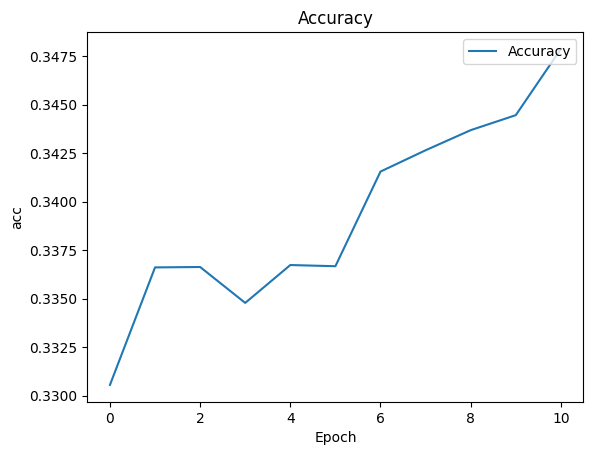

In [18]:
# Acc의 추이 확인
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend(['Accuracy'], loc='upper right')
plt.show()

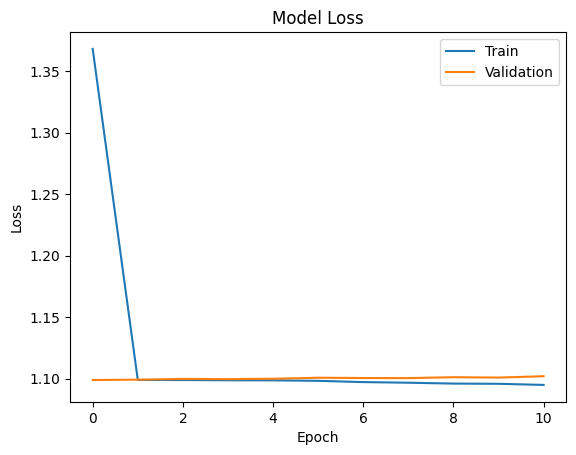

In [19]:
# 학습 손실과 검증 손실의 추이 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


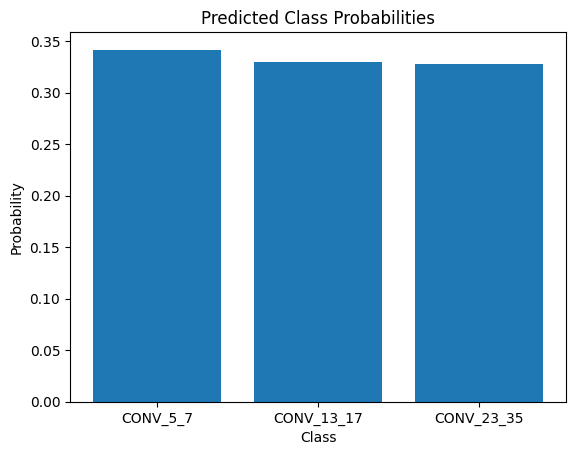

In [21]:
# Check predict calsprobabilities
Y_predict = model_cnn.predict(X_test)

result_array = np.array(Y_predict)

class_labels = classes

rand = random.randrange(0, len(Y_predict)-1)

# 막대 그래프 생성
plt.bar(class_labels, result_array[rand])

# 축 및 제목 설정
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Predicted Class Probabilities')

# 그래프 출력
plt.show()

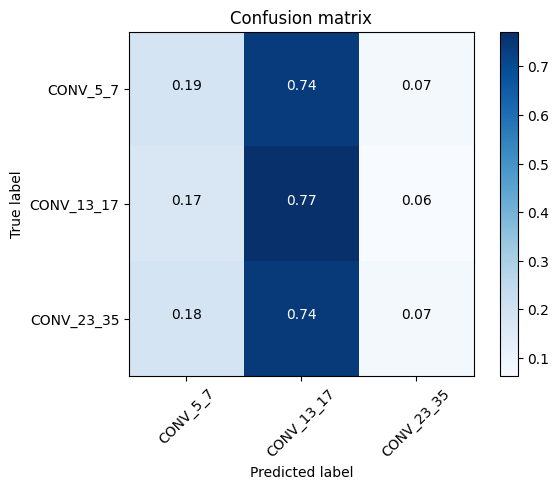

In [22]:
# Calculate confusion matrix
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(Y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
# Plot confusion matrix
plot_confusion_matrix(confnorm, labels=classes)


SNR -20dB:
5/5 - 0s - 35ms/step - accuracy: 0.3133 - loss: 1.0990

SNR -19dB:
5/5 - 0s - 8ms/step - accuracy: 0.3442 - loss: 1.0979

SNR -18dB:
5/5 - 0s - 6ms/step - accuracy: 0.3446 - loss: 1.0983

SNR -17dB:
6/6 - 0s - 8ms/step - accuracy: 0.3294 - loss: 1.0988

SNR -16dB:
5/5 - 0s - 6ms/step - accuracy: 0.3111 - loss: 1.0993

SNR -15dB:
5/5 - 0s - 6ms/step - accuracy: 0.2953 - loss: 1.0993

SNR -14dB:
6/6 - 0s - 8ms/step - accuracy: 0.3140 - loss: 1.0988

SNR -13dB:
5/5 - 0s - 5ms/step - accuracy: 0.4250 - loss: 1.0978

SNR -12dB:
4/4 - 0s - 7ms/step - accuracy: 0.3276 - loss: 1.0986

SNR -11dB:
5/5 - 0s - 8ms/step - accuracy: 0.2877 - loss: 1.0989

SNR -10dB:
6/6 - 0s - 7ms/step - accuracy: 0.3395 - loss: 1.0992

SNR -9dB:
6/6 - 0s - 6ms/step - accuracy: 0.3468 - loss: 1.0981

SNR -8dB:
5/5 - 0s - 6ms/step - accuracy: 0.3264 - loss: 1.0992

SNR -7dB:
5/5 - 0s - 4ms/step - accuracy: 0.3154 - loss: 1.1003

SNR -6dB:
5/5 - 0s - 7ms/step - accuracy: 0.2975 - loss: 1.0990

SNR -5dB:
5/

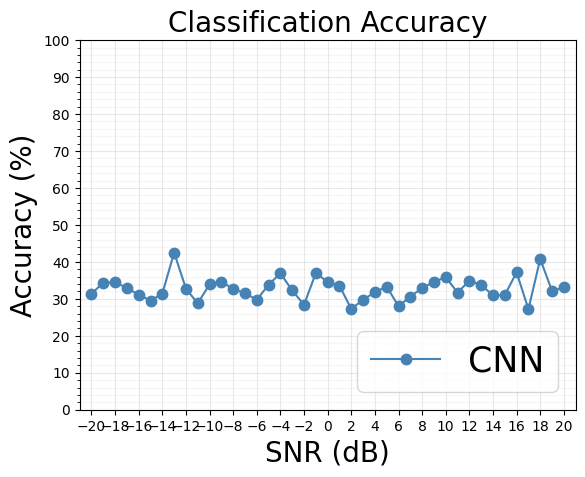

In [ ]:
# Plot classfication accuracy by each SNR
acc = SNR_accuracy(snr, model_cnn, 'CNN')